In [1]:
### PYTHON IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from random import shuffle
import librosa



In [2]:
### LOAD ALL FILE PATHS TO ARRAY

cwd = os.getcwd()
dataPath = 'data'
pathToData = os.path.join(cwd, dataPath)

# USABLE CLASSES
# bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, right, seven, sheila
# six, stop, three, tree, two, up, wow, yes, zero

#wordsToTrain = 'bed,cat,dog,eight,wow,house,tree,six,nine,sheila'
# AUDIO MNIST
wordsToTrain = 'zero,one,two' #,three,four,five,six,seven,eight,nine'
wordsToTrain_Array = wordsToTrain.split(',')

numberOfClasses = len(wordsToTrain_Array)

audioFiles = []
labelNames = []
classIndex = -1


# Find all folders inside the data folder
for classFile in os.listdir(pathToData):
    # For all folders found that match the wordsToTrain
    
    if(classFile in wordsToTrain_Array):
        classIndex += 1
        labelNames.append(classFile)
        # Check inside every folder
        pathToClass =  os.path.join(pathToData, classFile)
        # Loop through all files found
        for audioFile in os.listdir(pathToClass):
            # If the file format is an audio file
            if(audioFile.endswith('.wav')):
                # append the file path and the correct label to the audio files list
                audioFiles.append([os.path.join(pathToClass,audioFile),classIndex])
shuffle(audioFiles)
                
print("Number of classes: " + str(numberOfClasses))            

Number of classes: 3


In [3]:
# LOAD ALL DATA TO ARRAYS

import matplotlib.pyplot as plt
import librosa.display

## Cross validation array structure

# Note - nearly 1700 datapoints for each class. 
# If limit data is used, reduce the number of files by 80%
limitData = True
percentOfData = 0.6

dataPoints = len(audioFiles)
if(limitData):
    dataPoints = int((dataPoints*percentOfData))

# Set size of training
trainingSize = int(0.65 * dataPoints)
# Set size of validation
validationSize = int(0.25 * dataPoints)
# Rest should then be the testing set
testingSize = int(dataPoints - (trainingSize + validationSize))

print("Number of datapoints are: ",dataPoints)
print("Training samples: ",trainingSize)
print("Validation samples: ",validationSize)
print("Testing samples: ", testingSize)
print("Sum of all sets is ",trainingSize+validationSize+testingSize)

# Streams - link holder
#https://blog.francoismaillet.com/epic-celebration/
#https://stackoverflow.com/questions/42625286/how-to-process-audio-stream-in-realtime

Number of datapoints are:  4271
Training samples:  2776
Validation samples:  1067
Testing samples:  428
Sum of all sets is  4271


In [4]:
def fileToSpectrogram(path, seconds=1):
    
    # TODO: Find a way to make all arrays matching dimensions by cutting part of their size
    y, sr = librosa.load(path)
    # Cut the audio to the first 1 seconds
    y = y[:seconds * sr] 
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
    return S    


def plotSpectrogram(spectrogram):
    plt.figure(figsize=(10, 4))
    spectrogramData = spectrogram['data']
    librosa.display.specshow(librosa.power_to_db(spectrogramData, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    
    plt.colorbar(format='%+2.0f dB')
    
    splitPath = spectrogram['filename'].split('\\')
    
    plt.title(spectrogram['labelName'] + "  -  " + splitPath[len(splitPath)-1])
    plt.tight_layout()
    plt.show()


def fileObjectToDataObject(fileObject):
    pathToSoundArray = fileToSpectrogram(fileObject[0])
    meanOfSound = pathToSoundArray.mean() * 0.01
    pathToSoundArray -= meanOfSound
    
    
    targetVector = np.zeros((1,numberOfClasses))[0]
    targetVector[fileObject[1]] = 1
    
    dataObject = {
        'filename' : fileObject[0],
        'data' : pathToSoundArray,
        'label' : targetVector,
        'labelName' : labelNames[fileObject[1]]
    }
    
    return dataObject

In [5]:
# CHANGE DATA TO ARRAY

trainingArray = []
validationArray = []
testingArray = []

# Load training data   # trainingSize
for i in range(trainingSize):
    newObject = fileObjectToDataObject(audioFiles[i])
    trainingArray.append(newObject)
    
for i in range(validationSize):
    # Get the correct index
    startIndex = i + trainingSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])

    validationArray.append(newObject)

for i in range(testingSize):
    # Get the correct index
    startIndex = i + trainingSize + validationSize
    newObject = fileObjectToDataObject(audioFiles[startIndex])
    testingArray.append(newObject)


## TODO: Fix the input files, some arrays have a different shape on Y [128,41] vs [128,44] ???

#IMAGE_HEIGHT   = 128 
#IMAGE_WIDTH    = 
#IMAGE_CHANNELS = 1 


0.707984184376
260.649418714
-0.00715135534213


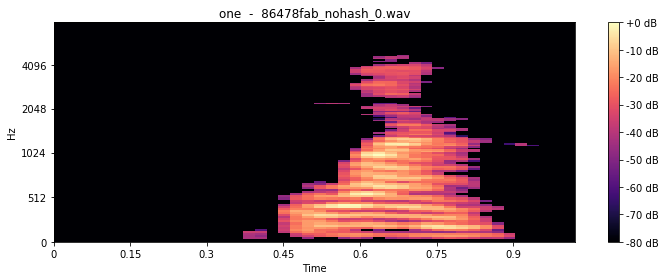

In [6]:
print(trainingArray[0]['data'].mean())
print(trainingArray[0]['data'].max())
print(trainingArray[0]['data'].min())

plotSpectrogram(trainingArray[333]) # 265

            

44
index  0


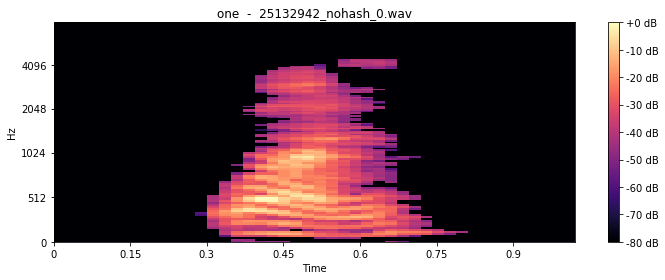

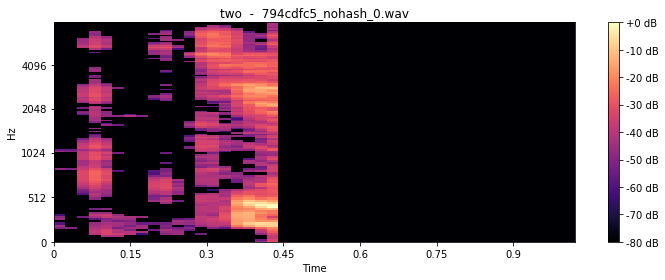

44
index  0


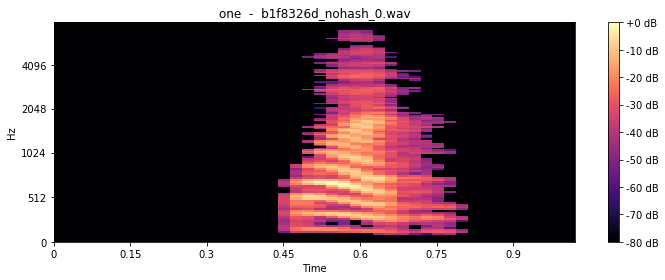

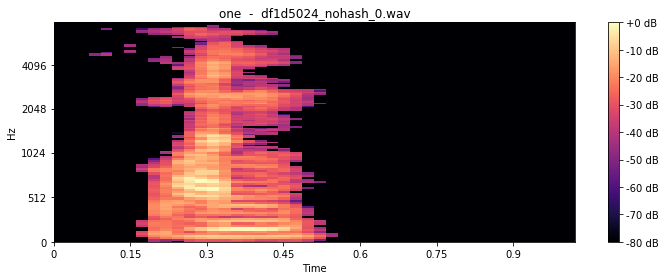

44
index  0


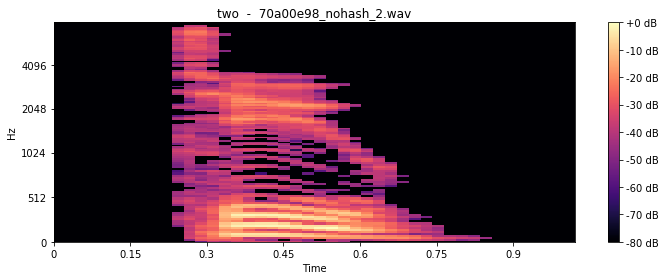

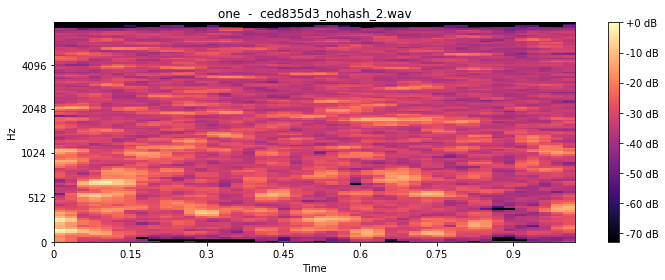

In [7]:
### NOTE 

"""
The code here below is the CNN structure that I used to my fruit project in the other course.
It doesn't work for this data since we need to restructure the data, layers, inputs and so on
I just put it here so you can see what the code looks like so we have a place to start :)


"""
def addSilenceToSet(aDataset):
    maxLen = 0
    minLen = 1000

    maxindex = 0
    minindex = 0
    for i in range(len(aDataset)):
        maxOfData = np.shape(aDataset[i]['data'])[1]
        if(maxOfData > maxLen):
            maxLen = maxOfData
            maxindex = i
        if(maxOfData < minLen):
            minLen = maxOfData
            minindex = i

    print(maxLen)
    print("index ", maxindex)
    spectoToPrint = aDataset[maxindex]
    plotSpectrogram(spectoToPrint)


    for i in range(len(aDataset)):
        if(np.shape(aDataset[i]['data'])[1] < maxLen):
            diff = maxLen - np.shape(aDataset[i]['data'])[1]
            emptyArray = np.zeros([128,diff])

            a = np.hstack((aDataset[i]['data'],emptyArray))
            aDataset[i]['data'] = a
            #if(i == minindex):
                #plotSpectrogram(spectoToPrint(trainingArray[i]))

    spectoToPrint = trainingArray[minindex]
    plotSpectrogram(spectoToPrint)   
    return maxLen

trainMaxLen = addSilenceToSet(trainingArray)
validMaxLen = addSilenceToSet(validationArray)
testMaxLen = addSilenceToSet(testingArray)



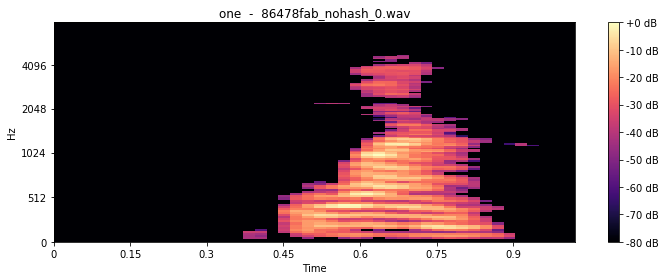

In [8]:
spectoToPrint = trainingArray[333]
plotSpectrogram(spectoToPrint)

#spectoToPrint = trainingArray[500]
#plotSpectrogram(spectoToPrint)
#spectoToPrint = trainingArray[501]
#plotSpectrogram(spectoToPrint)

In [43]:
# create some wrappers for simplicity
def conv2d(inputData,weights,bias,s=1):
    # conv2d wrapper, with bias and relu activation
    inputData = tf.nn.conv2d(inputData,weights,strides=[1,s,s,1],padding='SAME')
    inputData = tf.nn.bias_add(inputData,bias)
    return tf.nn.relu(inputData)

def maxpool2d(inputData,k=2,s=2):
    # max2d wrapper
    return tf.nn.max_pool(inputData,ksize=[1,k,k,1],strides=[1,s,s,1],padding='SAME')

def conv_net(inputData,weights,biases,dropout):
    inputData = tf.reshape(inputData, shape=[-1,128,trainMaxLen,1])
    #print('inputData shape:', inputData.shape)
    # convolustion layer
    conv1 = conv2d(inputData,weights['wc1'],biases['bc1'])
    print('conv1 shape:', conv1.shape)
    # max pooling

    conv1 = maxpool2d(conv1, k=2, s=2) # k = 3
    print('conv1 shape:', conv1.shape)
    # convolustion layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    print('conv2 shape:', conv2.shape)

    # max pooling 
    conv2 = maxpool2d(conv2, k=2, s=2)
    print('conv2 shape:', conv2.shape)
    
    # convolustion layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    print('conv3 shape:', conv3.shape)
    # max pooling 
    conv3 = maxpool2d(conv3, k=2, s=2)
    print('conv3 shape:', conv3.shape)
    
    # convolustion layer
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    #print('conv4 shape:', conv4.shape)
    # max pooling
    conv4 = maxpool2d(conv4, k=2, s=2)
    print('conv4 shape:', conv4.shape)
    
    # convolustion layer
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    print('conv5 shape:', conv5.shape)
    # max pooling 
    conv5 = maxpool2d(conv5, k=2, s=2)
    print('conv5 shape:', conv5.shape)
    
    return conv5

def mlp(finalConvLayer, weights, biases):
    
    # fully connected layer
    conv5Shape = finalConvLayer.get_shape().as_list()

    fc1 = tf.reshape(finalConvLayer, [-1, conv5Shape[1] * conv5Shape[2] * conv5Shape[3]])

    fc1 = tf.add(tf.matmul(fc1,weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    # TODO: Add 1 more layers
    fc2 = tf.add(tf.matmul(fc1,weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # output, class prediction
    out = tf.add(tf.matmul(fc2,weights['out']), biases['out'])

    # apply softmax in the end
    prediction = tf.nn.softmax(out)
    return prediction


def elm(convFinal, weights, biases):
    conv5Shape = convFinal.get_shape().as_list()
    fc1 = tf.reshape(convFinal, [-1, conv5Shape[1] * conv5Shape[2] * conv5Shape[3]])
    fc1 = tf.add(tf.matmul(fc1,weights['elm_wd1']), biases['elm_bd1'])
    fc1 = tf.nn.relu(fc1)
    return fc1

def elm_prediction(convFinal, weights, biases):
    conv5Shape = convFinal.get_shape().as_list()
    fc1 = tf.reshape(convFinal, [-1, conv5Shape[1] * conv5Shape[2] * conv5Shape[3]])
    fc1 = tf.add(tf.matmul(fc1,weights['elm_wd1']), biases['elm_bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    out = tf.add(tf.matmul(fc1,weights['elm_out']), biases['elm_out'])
    prediction = tf.nn.softmax(out)
    
    return prediction

In [44]:
# parameters

lr_start = 0.005
lr_end = 0.0001
learning_rate = lr_start

num_steps = 100
update_step = 5
display_step = 100
num_classes = numberOfClasses

num_input = 128*44*1
dropout = 0.5

# saver train parameters
useCkpt = False
checkpoint_step = 5
checkpoint_dir = os.getcwd()+'\\checkpoint\\'

In [45]:
# store layers weighta and bias
tf.reset_default_graph() 

weights = {
    # 5x5 conv, 3 inputs, 16 outpus
    'wc1': tf.get_variable('wc1',[7,7,1,32], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 16 input, 32 outpus
    'wc2': tf.get_variable('wc2',[5,5,32,64], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc3': tf.get_variable('wc3',[3,3,64,128], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 64 inputs, 128 outputs
    'wc4': tf.get_variable('wc4',[3,3,128,256], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    # 5x5 conv, 128 inputs, 256 outputs
    'wc5': tf.get_variable('wc5',[3, 3, 256, 512], initializer=tf.contrib.layers.xavier_initializer_conv2d()),

    # fully connected, 7*7*128 inputs, 2048 outputs
    'wd1': tf.get_variable('wd1',[4096,2048],initializer=tf.contrib.layers.xavier_initializer()),
    'wd2': tf.get_variable('wd2',[2048,100],initializer=tf.contrib.layers.xavier_initializer()),

    # fully connected, 7*7*128 inputs, 2048 outputs
    'elm_wd1': tf.get_variable('elm_wd1',[4096,100],initializer=tf.contrib.layers.xavier_initializer(), trainable=False),
    # 32 inputs, 26 outputs (class prediction)
    'out': tf.get_variable('out',[100,num_classes],initializer=tf.contrib.layers.xavier_initializer()),
    
    'elm_out': tf.get_variable('elm_out',[100,num_classes],initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'bc3': tf.Variable(tf.zeros([128])),
    'bc4': tf.Variable(tf.zeros([256])),
    'bc5': tf.Variable(tf.zeros([512])),
    'bd1': tf.Variable(tf.zeros([2048])),
    'elm_bd1': tf.Variable(tf.zeros([100])),

    'bd2': tf.Variable(tf.zeros([100])),
    'out': tf.Variable(tf.zeros([num_classes])),
    'elm_out': tf.Variable(tf.zeros([num_classes]))

}

In [46]:
### STACK THE DATA TO ARRAY 

batch_size = 64


# STACK TRAINING DATA AND LABELS FOR TRAINING
stackedTraining_Data = []
stackedTraining_Label = []
trainSamples = len(trainingArray)

for i in range(trainSamples):
    stackedTraining_Data.append(np.reshape(trainingArray[i]['data'], [1, num_input])[0])
    stackedTraining_Label.append(trainingArray[i]['label'])
    
nOfBatches = int(len(stackedTraining_Data) / batch_size)  
print("number of batches: " + str(nOfBatches))

# STACK VALIDATION DATA AND LABELS FOR VALIDATION
stackedValidation_Data = []
stackedValidation_Label = []
validationSamples = len(validationArray)

for i in range(validationSamples):
    stackedValidation_Data.append(np.reshape(validationArray[i]['data'], [1, num_input])[0])
    stackedValidation_Label.append(validationArray[i]['label'])
    
# STACK TESTING DATA AND LABELS FOR TESTING    
stackedTesting_Data = []
stackedTesting_Label = []
testingSamples = len(testingArray)

for i in range(testingSamples):
    stackedTesting_Data.append(np.reshape(testingArray[i]['data'], [1, num_input])[0])
    stackedTesting_Label.append(testingArray[i]['label'])


number of batches: 43


In [47]:
# NORMALIZE SECTION
maxVal = 0
minVal = 10000

for i in range(len(stackedTraining_Data)):
    maxVal = max(stackedTraining_Data[i].max(),maxVal)
    minVal = min(stackedTraining_Data[i].min(),minVal)

def normalizeArr(anArray):
    arr = anArray
    for i in range(len(anArray)):
        arr[i] = (anArray[i] - minVal) / (maxVal - minVal)
        
    return arr
    
stackedTraining_Data = normalizeArr(stackedTraining_Data)        
stackedValidation_Data = normalizeArr(stackedValidation_Data)        
stackedTesting_Data = normalizeArr(stackedTesting_Data)        



In [52]:
# ELM TRAINING
X = tf.placeholder(tf.float32,[None,num_input])
Y = tf.placeholder(tf.float32,[None,num_classes])
keep_prob = tf.placeholder(tf.float32)

convFinal_elm = conv_net(X,weights,biases,keep_prob)

elm_fc1 = elm(convFinal_elm, weights, biases)
output_weights = tf.matrix_solve_ls(elm_fc1,Y, l2_regularizer=0.0,fast=False,name=None)

weights_output = tf.assign( weights['elm_out'], output_weights, validate_shape=None, use_locking=None, name=None)

elm_logits = elm_prediction(convFinal_elm,weights,biases)

# evaluate model
correct_pred_elm = tf.equal(tf.argmax(elm_logits,1),tf.argmax(Y,1))
accuracy_elm = tf.reduce_mean(tf.cast(correct_pred_elm,tf.float32))



conv1 shape: (?, 128, 44, 32)
conv1 shape: (?, 64, 22, 32)
conv2 shape: (?, 64, 22, 64)
conv2 shape: (?, 32, 11, 64)
conv3 shape: (?, 32, 11, 128)
conv3 shape: (?, 16, 6, 128)
conv4 shape: (?, 8, 3, 256)
conv5 shape: (?, 8, 3, 512)
conv5 shape: (?, 4, 2, 512)


In [57]:
# tf graph input
#X = tf.placeholder(tf.float32,[None,num_input])
#Y = tf.placeholder(tf.float32,[None,num_classes])
#keep_prob = tf.placeholder(tf.float32)

# model construct
convFinal = conv_net(X,weights,biases,keep_prob)
mlp_logits = mlp(convFinal, weights, biases)
prediction = mlp_logits

# define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,
                                                                 labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss=loss_op)

# evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

# initialization
init = tf.global_variables_initializer()

trainCost = []
validCost = []

trainAcc = []
validAcc = []

def trainModel(data, targetVector, dataVal, targetVectorVal):
    
    for epoch in range(3): #, 10+1):#, num_steps + 1):
        print("epoch: " + str(epoch))

        #print(data[0].T.shape[0])
        
        #continue
        batch_x = data
        batch_y = targetVector
        
        with tf.Graph().as_default():

            for i in range(nOfBatches+1):
                #print("batch " + str(i))
                batch_x = data[i*batch_size:(i+1)*batch_size]
                batch_y = targetVector[i*batch_size:(i+1)*batch_size]

                # run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})


            lossTrain, accTrain = sess.run([loss_op,accuracy], feed_dict={X: data, Y: targetVector, keep_prob: dropout})
            print("Train-loss = " + "{:.8f}".format(lossTrain) + ", accuracy = " + "{:.4%}".format(accTrain))
            trainCost.append(lossTrain)
            trainAcc.append(accTrain)
            
            lossVal, accVal = sess.run([loss_op,accuracy], feed_dict={X: dataVal, Y: targetVectorVal, keep_prob: dropout})
            print("Valid-loss = " + "{:.8f}".format(lossVal) + ", accuracy = " + "{:.4%}".format(accVal))

            validCost.append(lossVal)
            validAcc.append(accVal)

            #if epoch % display_step == 0 or epoch == 1:
                #weight decay
                #learning_rate = updateLearningRate(acc, lr_start=lr_start)
                #if useCkpt:
                    #if epoch % checkpoint_step == 0:
                        #saver.save(sess, checkpoint_dir + 'model_epoch' + str(epoch) +'.ckpt')

def updateLearningRate(acc,lr_start):
    learning_rate_new = lr_start - acc*lr_start*0.9
    return learning_rate_new

saver = tf.train.Saver()

conv1 shape: (?, 128, 44, 32)
conv1 shape: (?, 64, 22, 32)
conv2 shape: (?, 64, 22, 64)
conv2 shape: (?, 32, 11, 64)
conv3 shape: (?, 32, 11, 128)
conv3 shape: (?, 16, 6, 128)
conv4 shape: (?, 8, 3, 256)
conv5 shape: (?, 8, 3, 512)
conv5 shape: (?, 4, 2, 512)


In [58]:
# TRAINING LOOP
with tf.Session() as sess:
    # run the initailizer
    sess.run(init)

    # train batch
    data, labels = stackedTraining_Data, stackedTraining_Label 
    dataVal, labelsVal = stackedValidation_Data, stackedValidation_Label 

    # create coord
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    """
    if useCkpt:
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            pass
    """
    # train the model
    trainModel(data, labels, dataVal, labelsVal)
    print("Optimization Finished! - Do ELM")
    #Performance before optimization
    #accVal = sess.run(accuracy_elm, feed_dict={X: dataVal, Y: labelsVal, keep_prob: 1})
    accValBef = sess.run(accuracy_elm, feed_dict={X: dataVal, Y: labelsVal, keep_prob: 1})

    print("Accuracy Before optimizing = " + "{:.4f}".format(accValBef))
    # train the model
    sess.run([weights_output], feed_dict={X: data,Y: labels, keep_prob: 1}) # Defines the input
    print("Optimization finish!")

    #Performance
    accValAft = sess.run(accuracy_elm, feed_dict={X: dataVal, Y: labelsVal, keep_prob: 1})
    print("Accuracy after optimizing = " + "{:.4f}".format(accValAft))
    print("ELM DONE")

    # close coord
    coord.request_stop()
    coord.join(threads)
    sess.close()

epoch: 0
Train-loss = 1.09923279, accuracy = 33.5375%
Valid-loss = 1.09877431, accuracy = 35.0515%
epoch: 1
Train-loss = 1.09882915, accuracy = 32.7089%
Valid-loss = 1.09852219, accuracy = 33.9269%
epoch: 2
Train-loss = 1.09823430, accuracy = 34.5101%
Valid-loss = 1.09772253, accuracy = 32.3336%
Optimization Finished! - Do ELM
Accuracy Before optimizing = 0.3299
Optimization finish!
Accuracy after optimizing = 0.3299
ELM DONE


In [ ]:
Training - loss = 1.09786701, accuracy = 33.5312%
Validation - loss = 1.09725630, accuracy = 31.7829%